In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm as tqdm_notebook

### Задача 1. CUPED (2.5 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [82]:
control_before = stats.expon(scale=1000).rvs(1000)

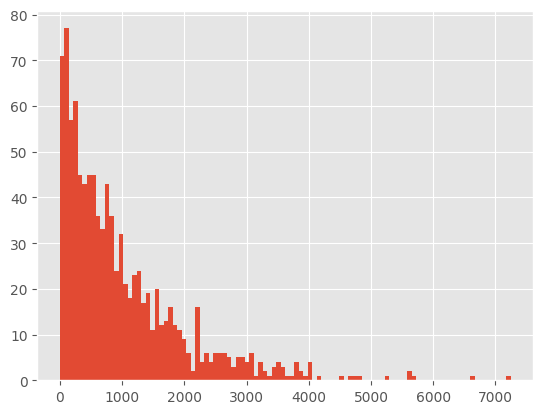

In [83]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [84]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000) # матожидание 0, дисперсия 100

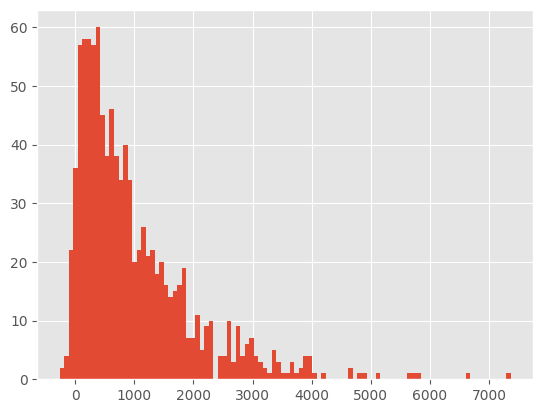

In [85]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [86]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
) # с вероятностью 95% наше среднее лежит в этом интервале

array([ 926.33743742, 1048.85158522])

In [87]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000) # То есть у нас увеличится дисперсия, но матожидание не поменяется
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000: # если 1000 не попадает в ДИ. Построение ДИ для выборки с большей дисперсией, но тем же средним и проверка того, что среднее не поменялось.
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в 5.06% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [90]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    # Рассчитаем оптимальный w для CUPED
    covariance = np.cov(control_before, control)[0, 1]
    variance = np.var(control)
    mean_Y = np.mean(control_before) # матожидание равно 1000 или mean Y????????????????????
    w = covariance / variance

    mean = (control - w*control_before + w*1000).mean() # + w*mean_Y
    std = (control - w*control_before + w*1000).std() / np.sqrt(len(control))
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975]) # Нужно ли домножать std на 1,96?

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  4.92% случаев;


Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [91]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10) # Всего 10000 семплов
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    ) # 1000 индексов берем на группу a
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a] # 1000 на группу b

    # берем по 1000 сэмплов в каждую группу
    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    # Добавляем шум
    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )

    control_after_full = control_before_full + stats.norm(loc=0, scale=100).rvs(10000)

    # Рассчитаем оптимальный w для CUPED по всей выборке. Поскольку w находится из условия минимизации дисперсии, то наиболее репрезентативным будет расчет по всей выборке
    covariance = np.cov(control_before_full, control_after_full)[0, 1]
    variance = np.var(control_after_full)
    w = covariance / variance

    control_cup_a = control_after_a - w*control_before_a + w*1000 #1000
    control_cup_b = control_after_b - w*control_before_b + w*1000 #1000

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  4.68% случаев;


Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:

У исходного распределения среднее значение равно 1000. Мы добавляем эффект и находим процент наблюдений, где 1000 не попадает в интервал. Получаем, что всего в 5% случаев у нас добавился эффект и поменялось среднее (потому что ДИ строили для среднего)

1) Затем мы считаем cuped метрику и строим доверительный интервал среднего для CUPED метрики и также смотрим % наблюдений, для которых 1000 не попадает в доверительный интервал, значение теперь меньше и составляет 4.93%. Это говорит о том, что CUPED метрика помогает нам снизить дисперсию и определить, что эффекта в эксперименте нет, поменялась только дисперсия. CUPED как раз помог нам снизить дисперсию и понять, что на самом деле эффекта нет. То есть наша ошибка первого рода стала меньше (мы реже утверждаем, что среднее поменялось ($H_1$), хотя на самом деле это не так ($H_0$ is true).

2) Теперь мы берем две группы из доэкспериментной выборки, применяем эффект, считаем CUPED для каждой группы, снижая дисперсию, (при этом w считаем по всей выборке, так как нам нужно минимизировать дисперсию нашей метрики cuped и w по всей выборке будет менее шумной оценкой, чем для каждой выборки) и сравниваем их между собой на равенство распределений. Наша О1Р стала еще меньше, но также близка к 0.05. То есть в 4.74% случаев мы утверждаем, что среднее между группами поменялось, хотя это не так.

Этот эффект связан с тем, что мы как бы бутстрапируем выборку, у нас появляется эффект бутстрапа, который и делает наши результаты более верными: на каждой итерации мы семплим выборку и считаем наши метрики, при большом числе итераций, а оно у нас 10000, что отлично для бутстрапа, а также семплы размера 1000, мы как раз добиваемся несмещенной оценки и более качественных результатов. Это как бутстрап + CUPED

Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [92]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=10, scale=100).rvs(
        samples_in_ab // 2
    )

    control_after_full = control_before_full + stats.norm(loc=10, scale=100).rvs(10000)

    # Рассчитаем оптимальный w для CUPED по всей выборке. Поскольку w находится из условия минимизации дисперсии, то наиболее репрезентативным будет расчет по всей выборке
    covariance = np.cov(control_before_full, control_after_full)[0, 1]
    variance = np.var(control_after_full)
    w = covariance / variance

    control_cup_a = control_after_a - w*control_before_a + w*1000 #np.mean(control_after_a)
    control_cup_b = control_after_b - w*control_before_b + w*1010 #np.mean(control_after_b)

    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05: # Проверяем, в скольких экспериментах мы нашли несоответствие между двумя выборками, при том что в группе b реально есть эффект (P(H1|H1)=beta)
        bad_cnt += 1

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1

print(
    f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев"
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  5.64% случаев; при использовании CUPED -- в 96.98% случаев


Полученные результаты характеризуют мощность: в скольких случаях мы находим статистически значимые различия при условии, что они реально есть. Мы видим, что при использовании CUPED наша мощность более высокая.

### Задача 2. Методы снижения дисперсии (2.5 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи:
- `None` - пользователь не участвует в АБ тесте,
- `*_before_i` - соответствующая группа до начала теста,
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение.

Считайте, что юзеры всегда идут в одном порядке в группах. То есть
data[data.group == 'control_before']
дает юзеров в той же последовательности, что
data[data.group == 'control_after_i']
для всех i.  Аналогичное верно для тритмента


#### Задание
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED.

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [151]:
import requests
from io import StringIO

url = 'https://drive.google.com/uc?export=download&id=1uAg3FOpnI-IbeKckQAGWFxCsN08AvRLm'
response = requests.get(url)
data = response.text
data = pd.read_csv(StringIO(data))

In [94]:
# data = pd.read_csv("data_ab.csv")

In [95]:
data.head()

,age,metric,group
0,young,11309.036916,treatment_before
1,young,8496.554679,control_before
2,young,11891.862586,control_before
3,young,9229.445011,treatment_before
4,young,10410.961279,control_before


In [96]:
data["group"].unique()

array(['treatment_before', 'control_before', nan, 'control_after_1',
       'treatment_after_1', 'control_after_2', 'treatment_after_2',
       'control_after_3', 'treatment_after_3', 'control_after_4',
       'treatment_after_4', 'control_after_5', 'treatment_after_5'],
      dtype=object)

In [97]:
data["age"].unique()

array(['young', 'adult', 'old'], dtype=object)

In [98]:
data[data.group == 'control_after_5']

,age,metric,group
91000,young,9109.208016,control_after_5
91001,young,12228.813543,control_after_5
91002,young,10303.207240,control_after_5
91003,young,11261.847300,control_after_5
91004,young,8720.725652,control_after_5
...,...,...,...
95495,old,7446.508586,control_after_5
95496,old,7349.510101,control_after_5
95497,old,8574.439844,control_after_5
95498,old,7520.131773,control_after_5


In [99]:
data[data.group == 'treatment_after_5']

,age,metric,group
95500,young,11086.638630,treatment_after_5
95501,young,10073.284614,treatment_after_5
95502,young,8919.052910,treatment_after_5
95503,young,9687.284297,treatment_after_5
95504,young,9496.133555,treatment_after_5
...,...,...,...
99995,old,7890.224384,treatment_after_5
99996,old,8165.046263,treatment_after_5
99997,old,10034.632118,treatment_after_5
99998,old,7564.445251,treatment_after_5


### 1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

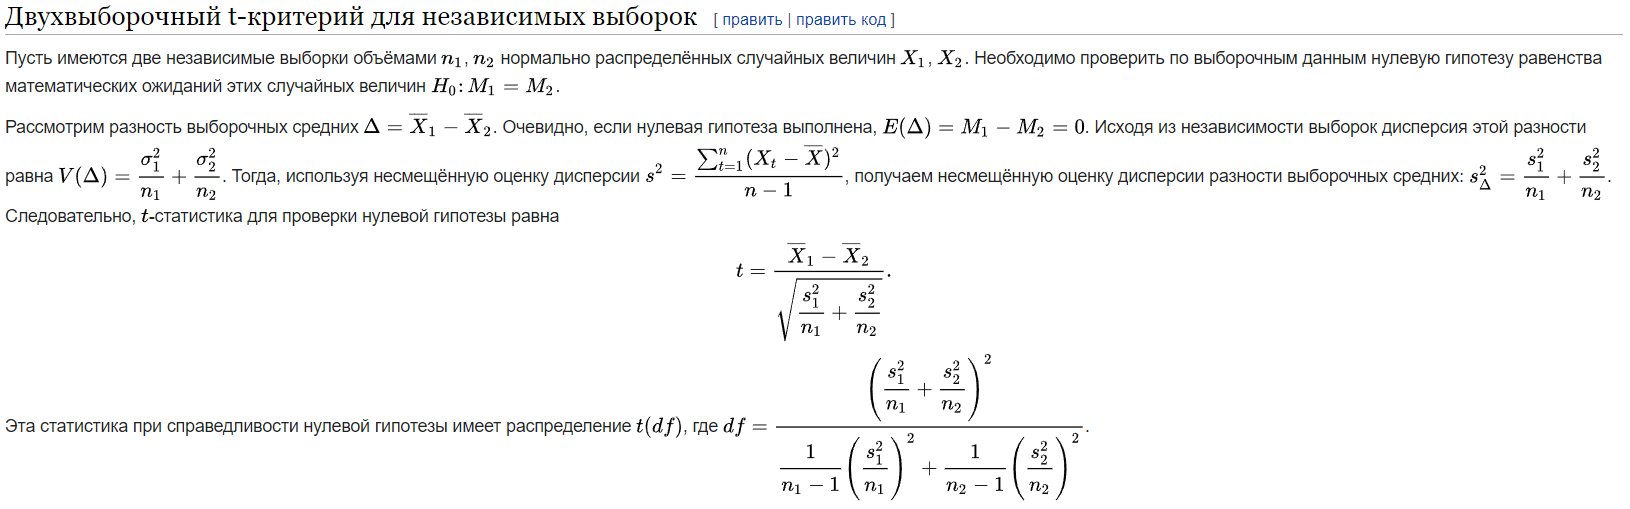

In [100]:
import numpy as np
def independent_ttest(control, test):
    # выборочные средние по выборкам
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    # выборочные дисперсии
    var_control = np.var(control, ddof=1)
    var_test = np.var(test, ddof=1) # ddof параметр указывает именно, что мы считаем выборочную дисперсию, которая делится не на N, а на N-1
    # размеры выборок
    n_control = len(control)
    n_test = len(test)
    # знаменатель t-статистики
    denominator = np.sqrt(var_control / n_control + var_test**2 / n_test)

    t_statistic = (mean_control - mean_test) / denominator
    df = (var_control/n_control + var_test/n_test)**2 / ((var_control/n_control)**2 / (n_control - 1) + (var_test/n_test)**2 / (n_test - 1))
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df))

    return t_statistic, p_value, df

# Проверка
sample1 = np.random.normal(loc=5, scale=100, size=10000)
sample2 = np.random.normal(loc=5, scale=1, size=10000)

t_statistic, p_value, df = independent_ttest(sample1, sample2)
print("t-статистика:", t_statistic)
print("p-value:", p_value)
print("Количество степеней свободы:", df)
stats.ttest_ind(sample1, sample2)[1]

t-статистика: 0.487398114377997
p-value: 0.6259869125516029
Количество степеней свободы: 10001.032408513383


0.6259814090312639

### 2. Реализуйте пост-стратификацию и CUPED.

In [152]:
control = pd.DataFrame()
treatment = pd.DataFrame()
for i in range(1, 6):
    control[f"control_after_{i}"] = data.loc[data['group'] == f'control_after_{i}', 'metric'].reset_index(drop=True)
    treatment[f"treatment_after_{i}"] = data.loc[data['group'] == f'treatment_after_{i}', 'metric'].reset_index(drop=True)
control["control_after_mean"] = control.mean(axis=1)
treatment["treatment_after_mean"] = treatment.mean(axis=1)

# After 0 - это before experiment
control["control_after_0"] = data.loc[data['group'] == f'control_before', 'metric'].reset_index(drop=True)
treatment["treatment_after_0"] = data.loc[data['group'] == f'treatment_before', 'metric'].reset_index(drop=True)

In [103]:
control.head()

,control_after_1,control_after_2,control_after_3,control_after_4,control_after_5,control_after_mean,control_after_0
0,8741.374306,9113.675629,8953.734508,9030.087523,9109.208016,8989.615996,8496.554679
1,11818.071476,12178.351619,12299.423731,12407.289137,12228.813543,12186.389901,11891.862586
2,10514.956374,10392.345494,10565.624681,10481.514484,10303.207240,10451.529655,10410.961279
3,11581.819650,11614.698805,11360.963325,11398.372159,11261.847300,11443.540248,11408.008048
4,9040.645542,8857.876154,8818.595660,8604.821519,8720.725652,8808.532905,9180.738281


Проверим сначала, как соотносятся между собой тестовая и контрольная группы в каждый день до и после эксперимента. Для этого проведем т-тест между соответствующими группами.

In [104]:
import random
for i in range(6):
    contr_sample = control[f"control_after_{i}"]
    treat_sample = treatment[f"treatment_after_{i}"]
    _, p = stats.ttest_ind(contr_sample, treat_sample)
    print(f'p-value t-test между control_after_{i} и treatment_after_{i}: {p}') # np.sum([1 for p in pvalues if p < 0.05]) / N

p-value t-test между control_after_0 и treatment_after_0: 0.9642001147036258
p-value t-test между control_after_1 и treatment_after_1: 0.6922472240558739
p-value t-test между control_after_2 и treatment_after_2: 0.4033494779637814
p-value t-test между control_after_3 и treatment_after_3: 0.23366578647283137
p-value t-test между control_after_4 и treatment_after_4: 0.12149348898963622
p-value t-test между control_after_5 и treatment_after_5: 0.05381516856747038


t-test показывает, что нет отличий между группами во все периоды. Лишь в последний день отличия начали становиться значимыми

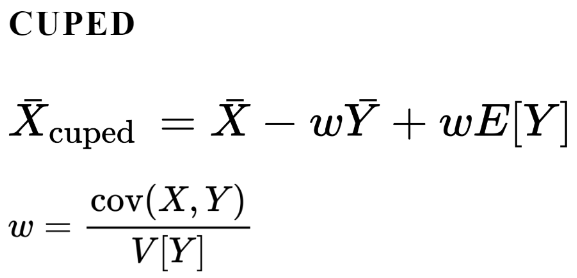

In [106]:
Y_bar_control = control["control_after_0"]
Y_bar_treatment = treatment["treatment_after_0"]
X_bar_control = control["control_after_mean"]
X_bar_treatment = treatment["treatment_after_mean"]

covariance = np.cov(Y_bar_control, X_bar_control)[0, 1]
variance = np.var(Y_bar_control)
w = covariance / variance

for i in range(1, 6):
    contr_sample_cup = control[f"control_after_{i}"] - w*Y_bar_control + w*Y_bar_control.mean()
    treat_sample_cup = treatment[f"treatment_after_{i}"] - w*Y_bar_treatment + w*Y_bar_treatment.mean()
    t_stat, p_ttest = stats.ttest_ind(contr_sample_cup, treat_sample_cup)
    # p_ks = stats.kstest(contr_sample_cup, treat_sample_cup).pvalue
    print(f't-test между control_after_{i} и treatment_after_{i} p-value: {p_ttest:.2f}') # , тест Колмогорова-Смирнова на равенство распределений: {p_ks:.2f}

t-test между control_after_1 и treatment_after_1 p-value: 0.00
t-test между control_after_2 и treatment_after_2 p-value: 0.00
t-test между control_after_3 и treatment_after_3 p-value: 0.00
t-test между control_after_4 и treatment_after_4 p-value: 0.00
t-test между control_after_5 и treatment_after_5 p-value: 0.00


Видим, что с применением CUPED наша дисперсия уменьшилась и теперь у нас p-value одинаковый и маленький для всех тестов между группами до и после эксперимента.

Данные p-value говорят, что распределение CUPED метрик разное на уровне значимости 5%, а также что средние между группами отличаются на уровне значимости 5%.

In [ ]:
# Поделим данные на страты
# !pip install hvplot

In [158]:
# Нужен алгоритм для сравнения групп между собой
# По каждой страте нужно посчитать разницу между treatment и control
# Вычислим Y_strat
# Страты у нас - это возраст. Будем для контроля и тритмента искать стратифицированную оценку, а затем сравнивать группы между собой на основе стратифицированных оценок.
import warnings
warnings.filterwarnings("ignore")
# Среднее по young, adult, old
strats = ['young', 'adult', 'old']
def strata_mean(df): # для каждой страты мы суммируем среднее по группам
    get_sum = []
    for strat in strats:
        w_k = (df.age==strat).sum()/len(df) # считаем вес страты
        get_sum.append(w_k*df[df.age==strat].mean())
    return get_sum # стратифицированная оценка среднего

for i in range(1, 6):
    contr_st = strata_mean(data.loc[data["group"]==f"control_after_{i}", ['age', 'metric']])
    treat_st = strata_mean(data.loc[data["group"]==f"treatment_after_{i}", ['age', 'metric']])
    diff = [cs - ts for cs, ts in zip(contr_st, treat_st)]
    _, p_ttest = stats.ttest_1samp(diff, 0)
    print(f'p-value t-test между control_after_{i} и treatment_after_{i}: {p_ttest}')

p-value t-test между control_after_1 и treatment_after_1: [0.5074508]
p-value t-test между control_after_2 и treatment_after_2: [0.26239083]
p-value t-test между control_after_3 и treatment_after_3: [0.18362772]
p-value t-test между control_after_4 и treatment_after_4: [0.13767509]
p-value t-test между control_after_5 и treatment_after_5: [0.1226598]


t-test с применением стратификации показывает, что различий между группами нет.

### Задача 3. Линеаризация + CUPED (2 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метрик.

In [113]:
url = 'https://drive.google.com/uc?export=download&id=1ZXrj8XXlKPX-Zwcaalrvttt514WHD-J9'
response = requests.get(url)
data = response.text
data2 = pd.read_csv(StringIO(data))

In [114]:
data2.head()

,Unnamed: 0,user_id,group,visit_id,visit_duration
0,0,JP1F82,first,ypn3ydiml32oelnslnjv,84.0
1,1,JP1F82,first,ypy93q2g8ypdtwbpv8b5,61.0
2,2,JP1F82,first,d8m6q0bmr40wgi6zuor3,81.0
3,3,JP1F82,first,5b72re4nr84fszqx7f6e,54.0
4,4,0Y2HSZ,first,z40pmuyaczi92gmlqz6t,97.0


Тест о равенстве средних длительностей визита с помощью линеаризации: 0.43727643231481905


  0%|          | 0/10000 [00:00<?, ?it/s]

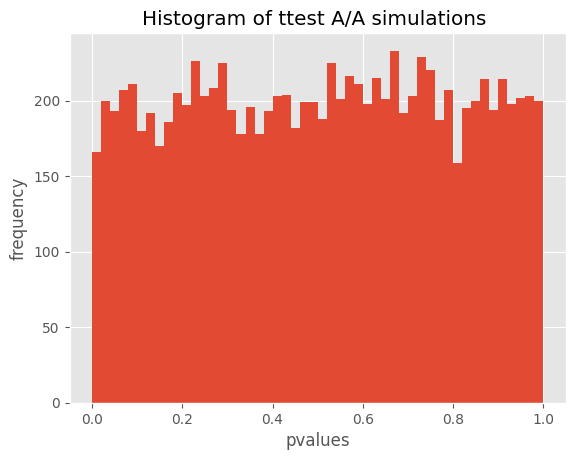

In [117]:
df_first = data2[data2.group == "first"]
df_second = data2[data2.group == "second"]
k = df_first.visit_duration.mean() # среднее по контролю

# Линеаризация - поюзерно посчитали для каждой группы отклонение от среднего юзера в контроле
df_first_l = df_first.groupby("user_id")["visit_duration"].sum() - k*df_first.groupby("user_id")["visit_duration"].count()
df_second_l = df_second.groupby("user_id")["visit_duration"].sum() - k*df_second.groupby("user_id")["visit_duration"].count()

_, p_value = stats.ttest_ind(df_first_l, df_second_l)
print(f'Тест о равенстве средних длительностей визита с помощью линеаризации: {p_value}')

simulations = 10000
n_s = 100
res = []

# Запуск симуляций A/A теста
for i in tqdm_notebook(range(simulations)):
  s1 = df_first_l.sample(n_s, replace = False).values
  s2 = df_second_l.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

p-value больше 0.05. Это говорит о том, что нулевая гипотеза о равенстве средних длительностей визита между двумя группами не отвергается на уровне значимости 5%, средние между группами равны. p-value распределен равномерно, что говорит, что группы похожи между собой, это две А группы.

#### Теперь проведем тест между группами A и B

In [118]:
url = 'https://drive.google.com/uc?export=download&id=1AOlhXzWttS9YF52VihjjJyXYPP7Z6tsu'
response = requests.get(url)
data = response.text
df = pd.read_csv(StringIO(data))

In [119]:
df.head()

,Unnamed: 0,user_id,group,visit_id,visit_duration
0,0,AOXLT0,a,76v7fwlgmxa73cx08zvh,125.0
1,1,AOXLT0,a,dse16a8xow680xn4ly3o,115.0
2,2,AOXLT0,a,ei17obrkatjb0uglqglr,117.0
3,3,AOXLT0,a,cp9aczsn0zd8a7u9qoel,115.0
4,4,AOXLT0,a,t421ljy1eg7qpdx3dask,123.0


Тест о равенстве средних длительностей визита с помощью линеаризации: 0.0569584460515404


  0%|          | 0/10000 [00:00<?, ?it/s]

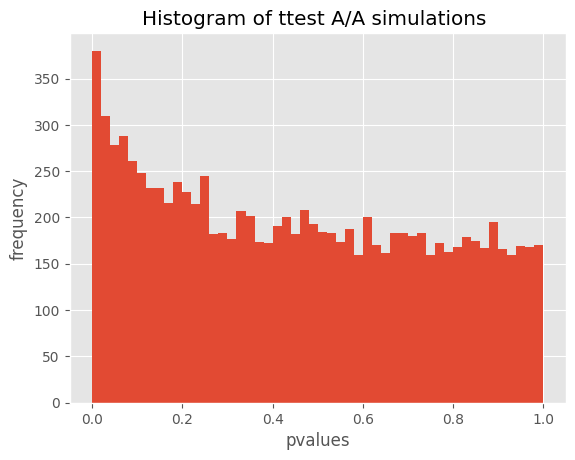

In [120]:
df_a = df[df.group == "a"]
df_b = df[df.group == "b"]
k = df_a.visit_duration.mean() # среднее по контролю

# Линеаризация - поюзерно посчитали для каждой группы отклонение от среднего юзера в контроле
df_a_l = df_a.groupby("user_id")["visit_duration"].sum() - k*df_a.groupby("user_id")["visit_duration"].count()
df_b_l = df_b.groupby("user_id")["visit_duration"].sum() - k*df_b.groupby("user_id")["visit_duration"].count()

_, p_value = stats.ttest_ind(df_a_l, df_b_l)
print(f'Тест о равенстве средних длительностей визита с помощью линеаризации: {p_value}')

simulations = 10000
n_s = 100
res = []

# Запуск симуляций A/A теста
for i in tqdm_notebook(range(simulations)):
  s1 = df_a_l.sample(n_s, replace = False).values
  s2 = df_b_l.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

На 5% уровне значимости гипотеза о равенстве средних длительностей визита не отвергается, различия в средних между группами a и b статистически незначимые.

Наш p-value как раз чуть больше 0.05, нулевая гипотеза не отвергается на 5% уровне значимости, средняя длительность визита между группами A и B равны, эффекта никакого нет, при этом распределение очень похоже на равномерное, однако неравномерное

In [121]:
url = 'https://drive.google.com/uc?export=download&id=1AvcONLLos_znWjbdOR53KToyV_su0r55'
response = requests.get(url)
data = response.text
data3 = pd.read_csv(StringIO(data))

In [122]:
data3.head()

,Unnamed: 0,user_id,visit_id,visit_duration
0,0,66U21N,2e9jn4qdjoot4vo9xn5g,76.0
1,1,MQE6TJ,v54g9sa6g6gcn6f7e3kk,97.0
2,2,X4A2B6,zmz8g1utfal68e1ctz8g,117.0
3,3,HFYD47,e8zvlx05icmrcn75ny5u,49.0
4,4,8C8XIX,886rt54buvgrtgah1i1f,83.0


In [123]:
df_hist = data3.groupby('user_id')['visit_duration'].mean()
df_after = df.groupby('user_id')['visit_duration'].mean()

In [124]:
merged_data = df_hist.reset_index().merge(df_after.reset_index(), on='user_id', suffixes=('_hist', '_after'))
final_data = merged_data.merge(df[['user_id', 'group']], on='user_id').drop_duplicates(subset=['user_id'])
final_data.head()

,user_id,visit_duration_hist,visit_duration_after,group
0,01R0ZS,94.500000,100.250000,a
4,037ZNF,87.000000,86.200000,a
9,03F8XE,58.111111,110.000000,a
15,044XWI,102.833333,78.111111,b
24,058JNQ,90.333333,88.857143,b


In [125]:
df_hist_a = final_data[final_data.group == "a"]["visit_duration_hist"]
df_after_a = final_data[final_data.group == "a"]["visit_duration_after"]

df_hist_b = final_data[final_data.group == "b"]["visit_duration_hist"]
df_after_b = final_data[final_data.group == "b"]["visit_duration_after"]

covariance = np.cov(final_data["visit_duration_hist"], final_data["visit_duration_after"])[0, 1]
variance = np.var(final_data["visit_duration_hist"])
w = covariance / variance

a_cup = df_after_a - w*df_hist_a + w*df_hist_a.mean()
b_cup = df_after_b - w*df_hist_b + w*df_hist_b.mean()
t_stat, p_ttest = stats.ttest_ind(a_cup, b_cup)
# p_ks = stats.kstest(contr_sample_cup, treat_sample_cup).pvalue
print(f't-test между a_cup и b_cup p-value: {p_ttest:.2f}')

t-test между a_cup и b_cup p-value: 0.12


Тест показывает, что среднее между группами не отличается на уровне значимости 5%.

### Задача 4. Последовательное тестирование (3 балла)

Сгенерируйте две контрольные выборки и одну тестовую (с эффектом). Проведите последовательные АА-тесты и АБ-тесты по следующей схеме:

1. Попробуйте использовать t-test. Начните с 1 наблюдения в группах и последовательно добавлять по одному в каждую. Проследите, как меняется О1Р, О2Р.

2. Самостоятельно реализуйте **SPRT-тест Вальда** и проделайте ту же процедуру с ним. Что теперь происходит с О1Р и О2Р? Почему?

In [135]:
n = 1000
alpha = 0.05
beta = 0.2

control_group_A = stats.expon(scale=100).rvs(n)
control_group_B = stats.expon(scale=100).rvs(n)
test_group_B = stats.expon(scale=120).rvs(n)

A = []
B = []
pvalues_AA = []

for i in tqdm_notebook(range(n)):
  A.append(control_group_A[i])
  B.append(control_group_B[i])
  _, p_value = stats.ttest_ind(A, B)
  pvalues_AA.append(p_value)

A = []
B = []
pvalues_AB = []

for i in tqdm_notebook(range(n)):
  A.append(control_group_A[i])
  B.append(test_group_B[i])
  _, p_value = stats.ttest_ind(A, B)
  pvalues_AB.append(p_value)

cnt_AA = sum(p < alpha for p in pvalues_AA)
prob_alpha_AA = cnt_AA / n

cnt_AB = sum(p > alpha for p in pvalues_AB)
prob_beta_AB = cnt_AB / n

print(f'Вероятность ошибки первого рода: {prob_alpha_AA}')
print(f'Вероятность ошибки второго рода: {prob_beta_AB}')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Вероятность ошибки первого рода: 0.316
Вероятность ошибки второго рода: 0.141


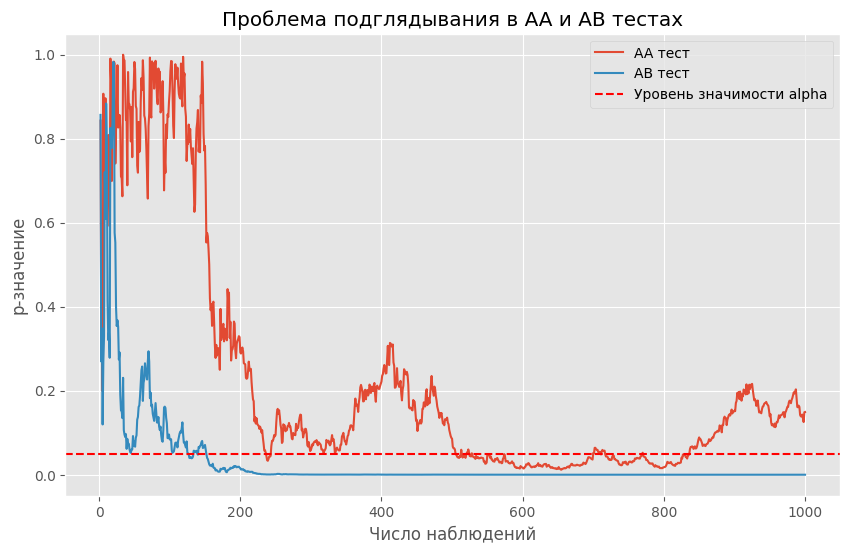

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n + 1), pvalues_AA, label='AA тест')
plt.plot(range(1, n + 1), pvalues_AB, label='AB тест')
plt.axhline(y=alpha, color='r', linestyle='--', label='Уровень значимости alpha')
plt.xlabel('Число наблюдений')
plt.ylabel('p-значение')
plt.title('Проблема подглядывания в AA и AB тестах')
plt.legend()
plt.show()

Мы видим, что AA тест в один момент пересекает уровень значимости alpha = 0.05. Однако если мы ждали бы пока это произойдет и приняли решение, как только p-value будет меньше уровня значимости, то мы неверно приняли бы альтернативную гипотезу (Потому что в AA тесте группы равны).

То же самое касается AB теста. Вначале, когда наблюдений мало, p-value демонстрирует, что различий между группами нет и только спустя время пррокрашивается. Если бы мы не дождались, то тест показал бы что эффекта нет, хотя на самом деле он есть.

Таким образом вероятность ошибки первого и второго рода растут при условии подглядывания и использования обычного тестирования, необходимо использовать последовательное тестирование.

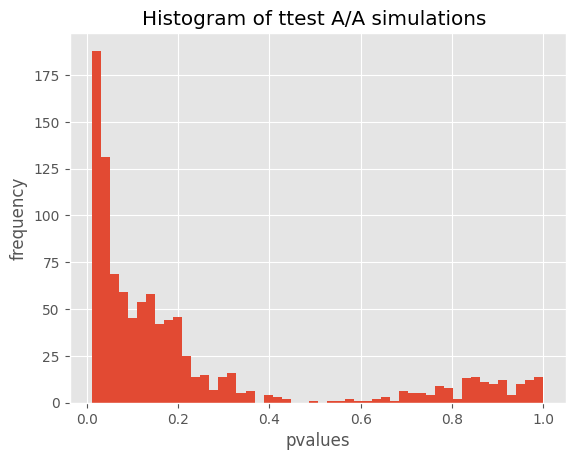

In [137]:
plt.hist(pvalues_AA, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

p-value для такого AA теста распределен неравномерно. Для AB тоже:

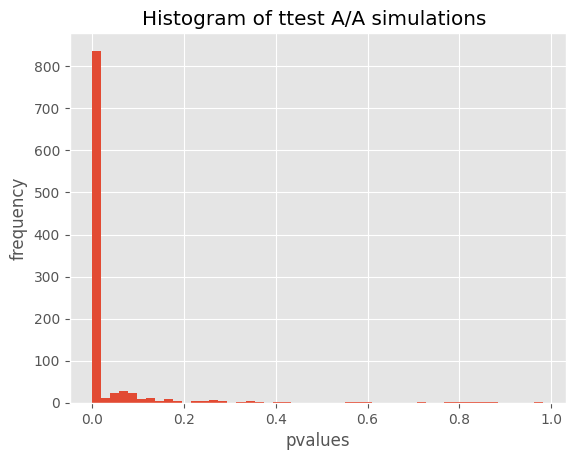

In [138]:
plt.hist(pvalues_AB, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

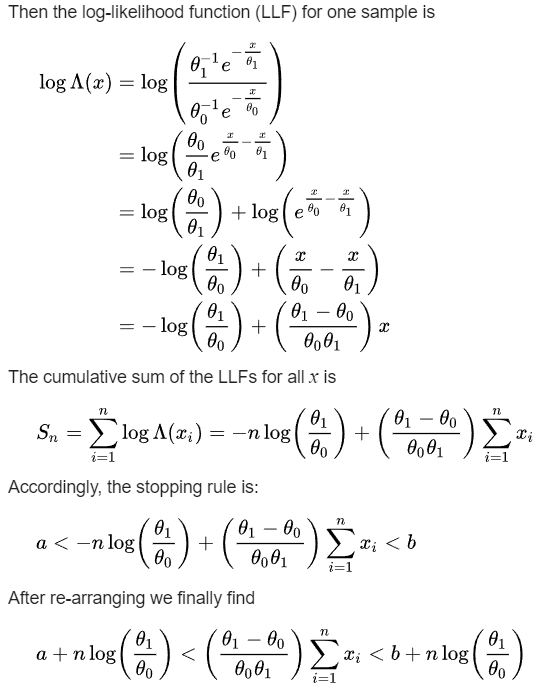

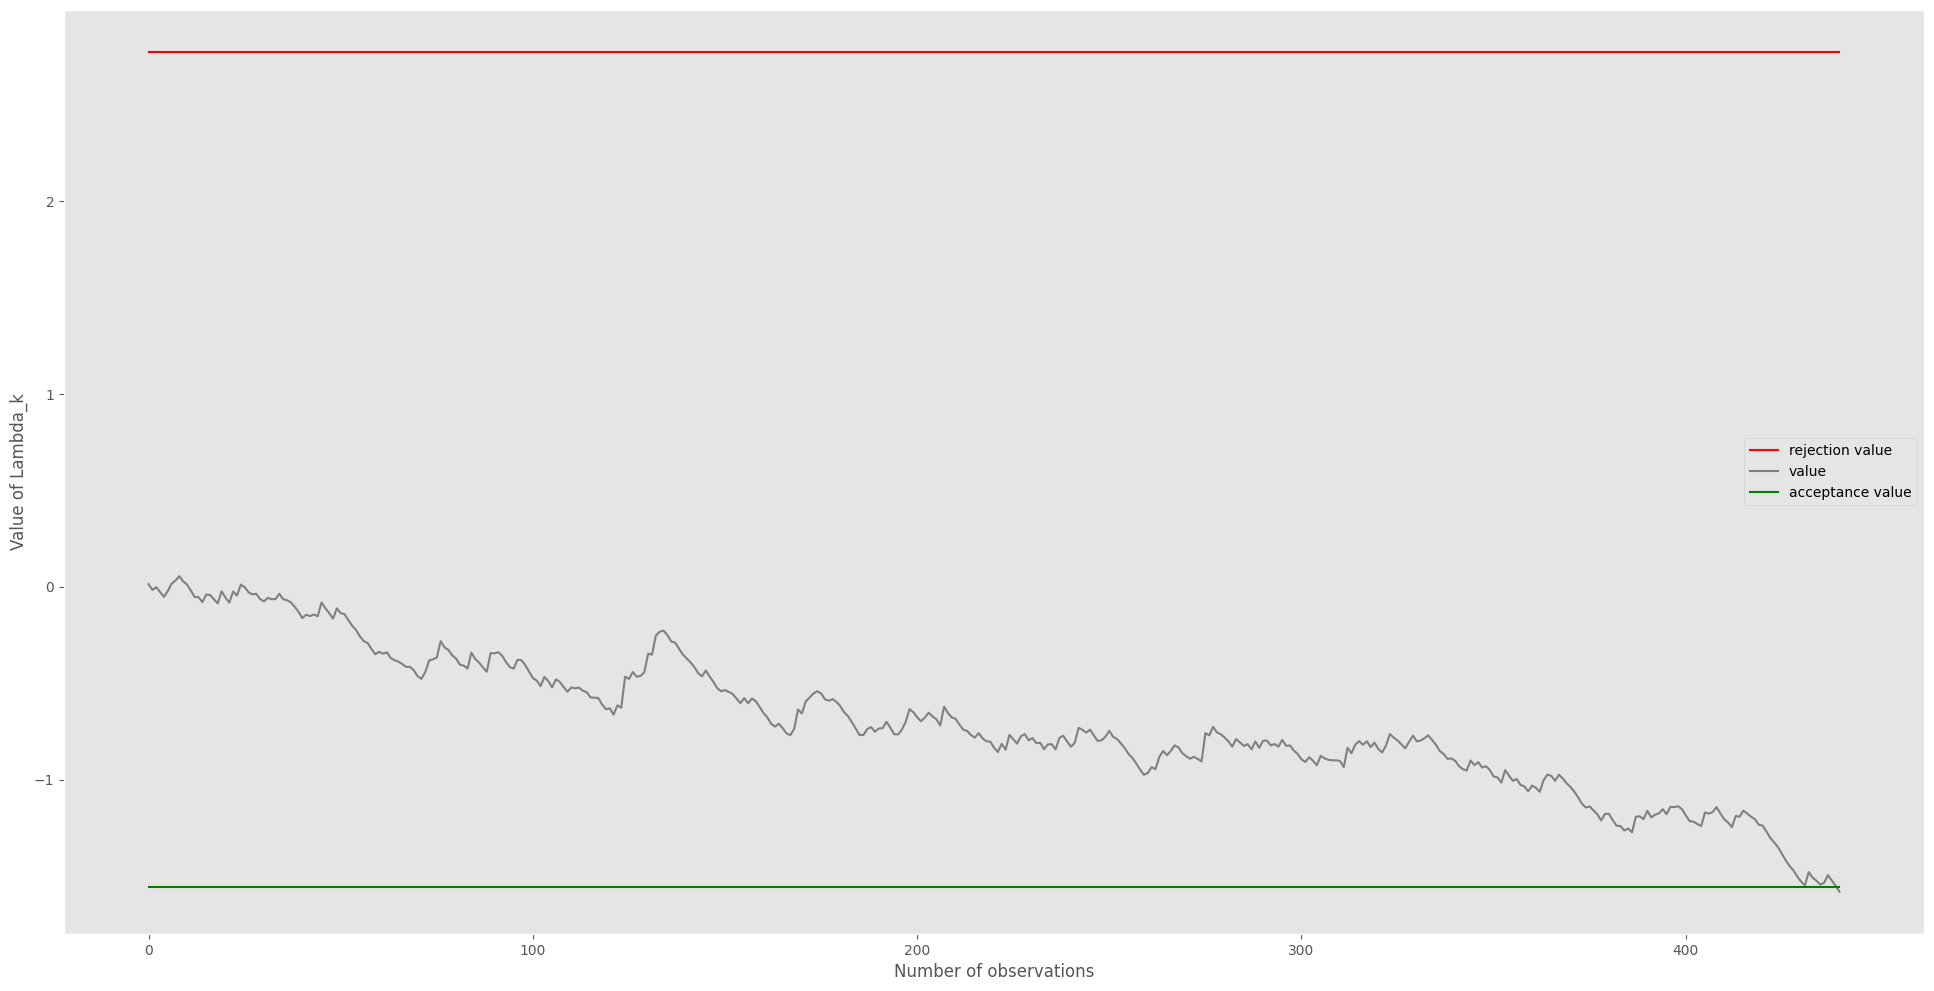

In [139]:
teta1 = 99.5
teta2 = 103
teta_real = 100

alpha = 0.05
beta = 0.2
n = 10000

data = np.random.exponential(scale=teta_real, size=n)

counter_acc = 0
L = []
U = []
V = [0]


for i in range(n):
    V.append(V[-1] + np.log(teta1/teta2) + (teta2 - teta1)/(teta1*teta2) * data[i])
    L.append(np.log(beta / (1 - alpha)))
    U.append(np.log((1 - beta) / alpha))

    if V[-1] < L[-1]:
        counter_acc += 1
        break
    if V[-1] > U[-1]:
        break
V = V[1:]


plt.figure(figsize=(24, 12))
plt.plot(U, label='rejection value', c='red')
plt.plot(V, label='value', color = 'gray')
plt.plot(L, label='acceptance value', c='green')

plt.xlabel('Number of observations')
plt.ylabel('Value of Lambda_k')
plt.grid()
plt.legend()
plt.show()

In [143]:
counter_acc = 0
for j in tqdm_notebook(range(10000)):
    data = np.random.exponential(scale=teta1, size=n)
    L = []
    U = []
    V = [0]
    for i in range(n):
        V.append(V[-1] + np.log(teta1/teta2) + (teta2 - teta1)/(teta1*teta2) * data[i])
        L.append(np.log(beta / (1 - alpha)))
        U.append(np.log((1 - beta) / alpha))
        if V[-1] < L[-1]: # Принимаем H0
            counter_acc += 1
            break
        if V[-1] > U[-1]:
            break
    V = V[1:]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [144]:
# Вероятность ошибки 1 рода
(10000 - counter_acc) / counter_acc

0.06134578645722776

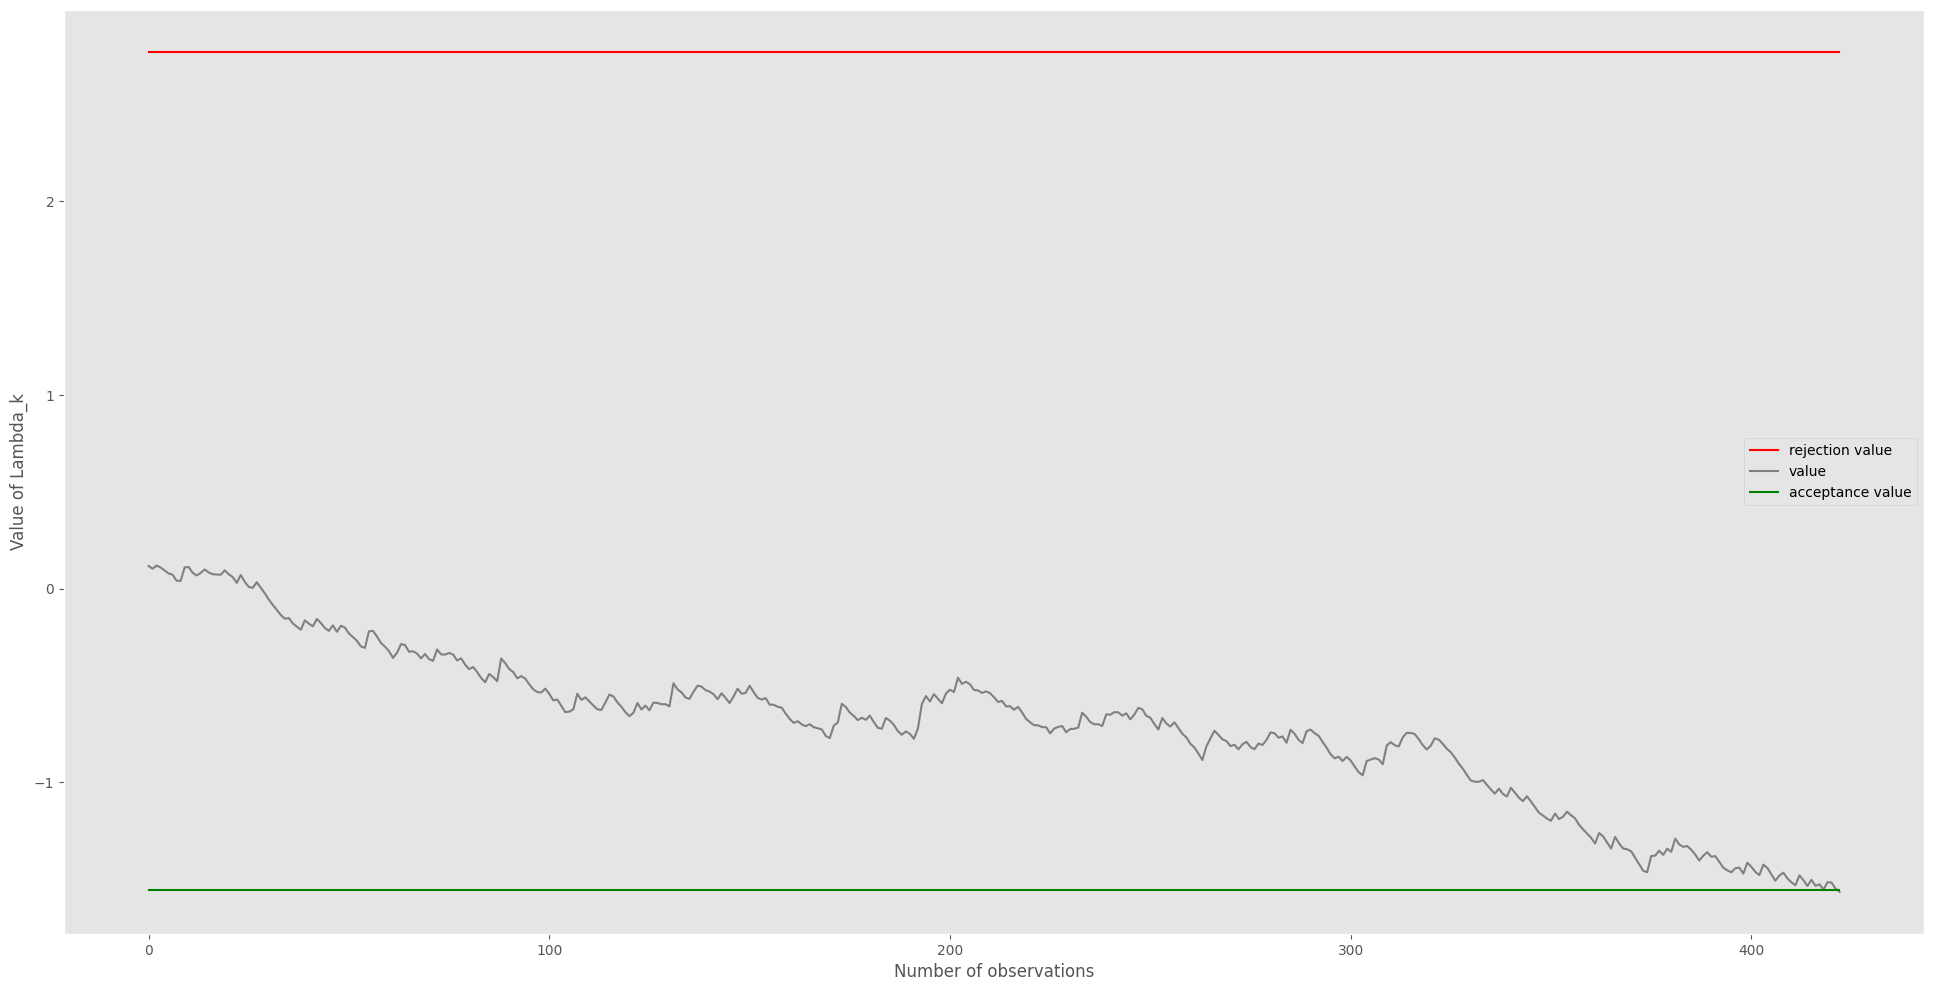

In [145]:
plt.figure(figsize=(24, 12))
plt.plot(U, label='rejection value', c='red')
plt.plot(V, label='value', color = 'gray')
plt.plot(L, label='acceptance value', c='green')

plt.xlabel('Number of observations')
plt.ylabel('Value of Lambda_k')
plt.grid()
plt.legend()
plt.show()

In [146]:
counter_acc = 0
for j in tqdm_notebook(range(10000)):
    data = np.random.exponential(scale=teta2, size=n)
    L = []
    U = []
    V = [0]
    for i in range(n):
        V.append(V[-1] + np.log(teta1/teta2) + (teta2 - teta1)/(teta1*teta2) * data[i])
        L.append(np.log(beta / (1 - alpha)))
        U.append(np.log((1 - beta) / alpha))
        if V[-1] < L[-1]: # принимаем H0
            counter_acc += 1
            break
        if V[-1] > U[-1]:
            break
    V = V[1:]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [147]:
# Вероятность ошибки 2 рода
counter_acc / 10000

0.1907

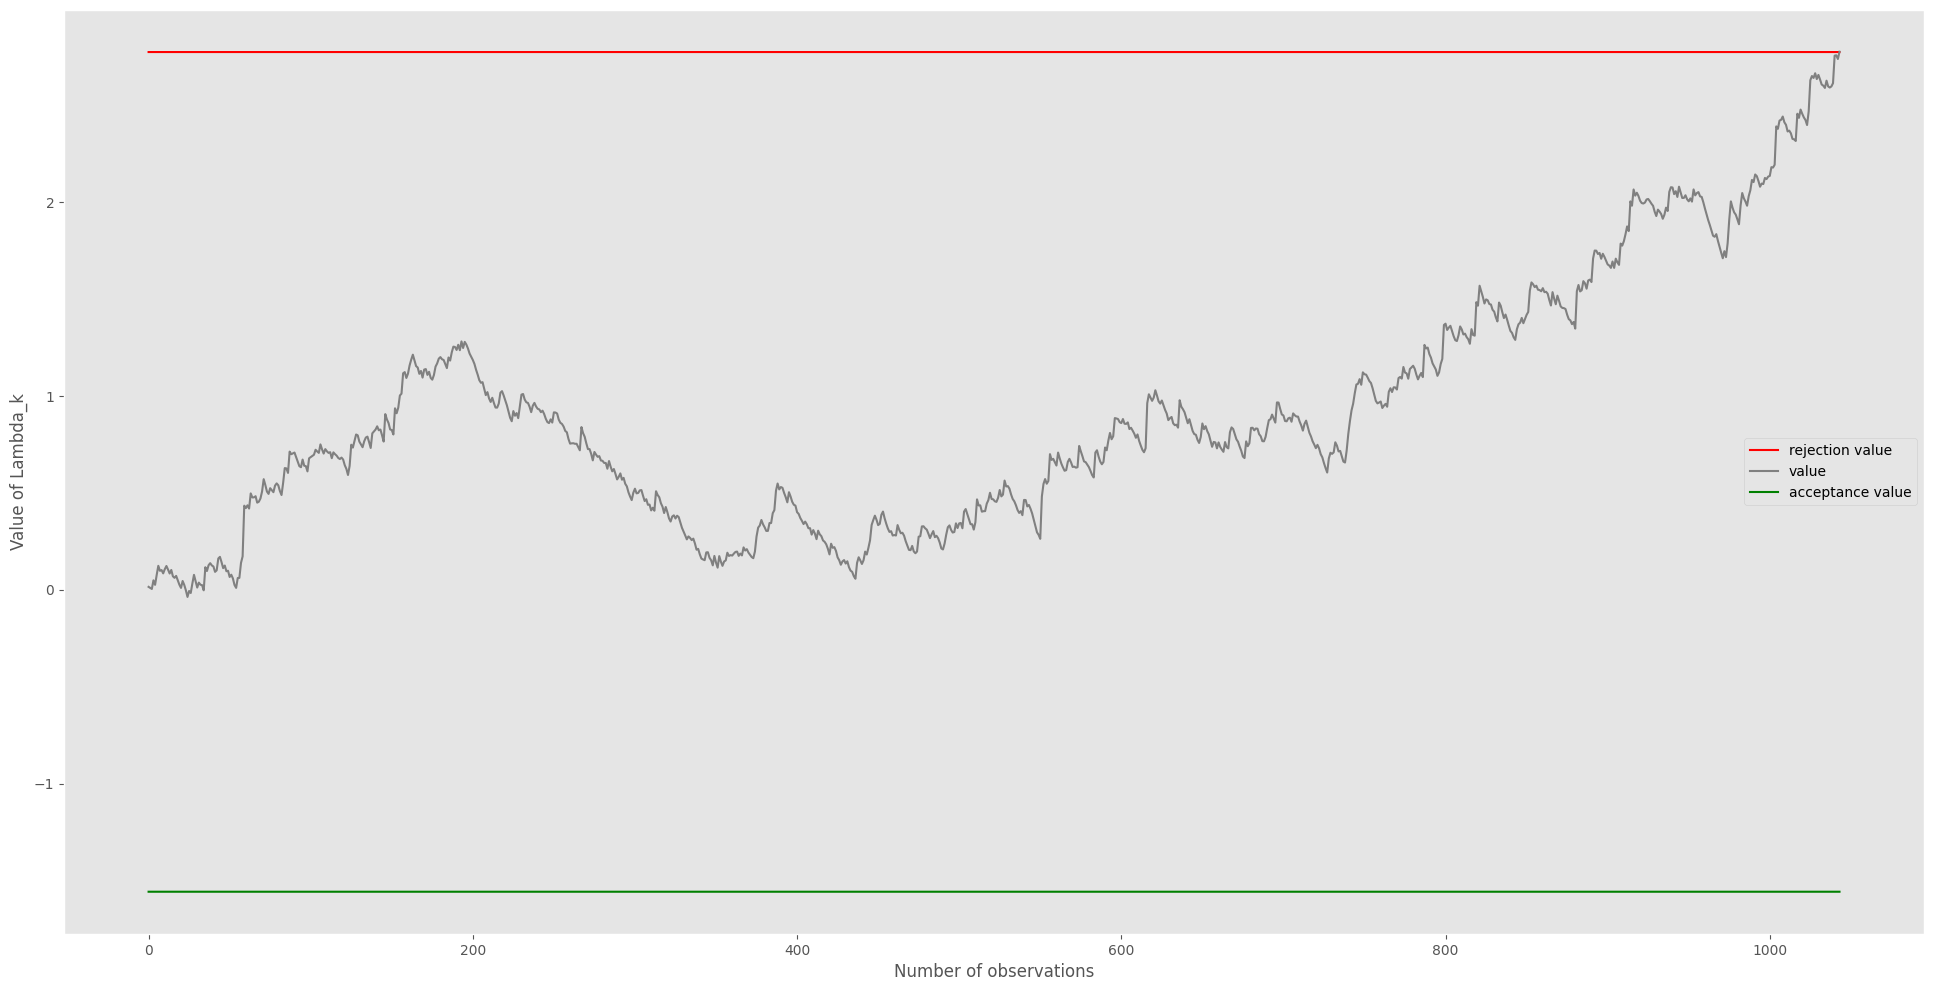

In [148]:
plt.figure(figsize=(24, 12))
plt.plot(U, label='rejection value', c='red')
plt.plot(V, label='value', color = 'gray')
plt.plot(L, label='acceptance value', c='green')

plt.xlabel('Number of observations')
plt.ylabel('Value of Lambda_k')
plt.grid()
plt.legend()
plt.show()

О1Р и О2Р нормализовались и стали на желаемом нами уровне.

### Задача 5. Бонус от лектора (5 баллов)

_3 балла за выполнение __всех__ пунктов 1-5. +2 балла за пункт 6, при условии, что пункты 1-5 выполнены._

1. Реализуйте mSPRT, предполагая, что функция правдободобия имеет нормальное распределение
2. Выведите теоретический вид статистики $\Lambda_n$ для нормального распределения
3. Постройте распределение времени остановки для mSPRT и распределение p-value на А/А тесте
4. Сделайте то же самое, но для синтетического А/В (добавьте искуственно эффект). Опишите, что поменялось
5. Сравните mSPRT с классическим t-test
6. Замените расчет интеграла  $\Lambda_n$ на численное приближение расчета. Сравните результаты по пункту 3 и 4